# Models

In [1]:
import time
import datetime
import numpy as np
import pandas as pd
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from pprint import pprint
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# %run /content/drive/MyDrive/DentistDataAnalysis/Experiments/Mappings.ipynb
%run Mappings.ipynb

In [3]:
# DIR = '/content/drive/MyDrive/DentistDataAnalysis/Experiments/'
DIR = ''

In [4]:
data = pd.read_csv(DIR+'dataset/final_data.csv')

In [5]:
X_cols = ['Que1', 'Que2', 'Que3', 'Que4', 'Que5', 'Que6', 'Que10_a', 'Que10_b', 'Que10_c', 'Que10_d', 'Que10_e', 'Que10_f', 'Que14', 'Que15', 'Que17', 'Que18_age', 'Que19', 'Que20', 'Que21', 'Que22', 'Que_smoking']
y_col = ['Que16']

## Logit

In [6]:
class SMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        yhat = self.results_.predict(X)
        return list(map(round, yhat))

In [7]:
def perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col):
    X_train_df = pd.DataFrame(data=X_train, columns=X_cols)
    y_train_df = pd.DataFrame(data=y_train, columns=y_col)
    logit_model = SMWrapper(sm.Logit)
    scores = cross_val_score(logit_model, X_train_df, y_train_df, scoring='recall', cv=5, n_jobs=-1)
    print('Mean cross-validation score: ')
    print(round(np.nanmean(scores), 4))
    X_train_df = sm.add_constant(X_train_df)
    logit = Logit(y_train_df, X_train_df)
    lg = logit.fit()
    print(lg.summary())
    X_test = sm.add_constant(X_test)
    yhat = lg.predict(X_test)
    prediction = list(map(round, yhat))
    get_metrics(y_test, prediction)   

## Random forest

In [8]:
def perform_random_forest(X_train, y_train, X_test, y_test):
    #hyperparameters config
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 150, num = 15)]
    criterion = ['gini', 'entropy']
    max_features = ['sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True]
    random_grid = {'n_estimators': n_estimators,
                   'criterion': criterion,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    #grid search config
    rf_scoring='recall'
    rf_cv = 5
    rf_verbose=1
    rf_n_jobs=-1
    rf_return_train_score=True
    rf = RandomForestClassifier()
    rf_grid = GridSearchCV(estimator=rf, 
                            param_grid=random_grid,
                            scoring=rf_scoring, cv=rf_cv, 
                            verbose=rf_verbose, n_jobs=rf_n_jobs, 
                            return_train_score=rf_return_train_score)
    start_time = time.time()
    rf_grid.fit(X_train, y_train)
    end_time = time.time()
    conv_time = datetime.timedelta(seconds=end_time-start_time)
    print(f"Grid search time: {conv_time}")
    
    print('Mean cross-validation score of best model: ')
    print(round(rf_grid.best_score_, 4))
    print('Best parameters:')
    pprint(rf_grid.best_params_)

    rf.set_params(bootstrap = rf_grid.best_params_['bootstrap'], 
                    criterion = rf_grid.best_params_['criterion'], 
                    max_depth = rf_grid.best_params_['max_depth'],
                    max_features = rf_grid.best_params_['max_features'],
                    min_samples_leaf = rf_grid.best_params_['min_samples_leaf'],
                    min_samples_split = rf_grid.best_params_['min_samples_split'],
                    n_estimators = rf_grid.best_params_['n_estimators'])
    rf.fit(X_train, y_train)
    prediction = rf.predict(X_test)
    pprint(rf.get_params())
    get_metrics(y_test, prediction)
    
    start_time = time.time()
    importances = rf_grid.best_estimator_.feature_importances_
    std = np.std([rf_grid.best_estimator_.feature_importances_ for tree in rf_grid.best_estimator_.estimators_], axis=0)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: " 
          f"{elapsed_time:.3f} seconds")
    forest_importances = pd.Series(importances, index=X_cols).sort_values(ascending=False)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

## Decision trees

In [9]:
def perform_decision_tree(X_train, y_train, X_test, y_test):
    #hyperparameters config
    criterion = ['gini', 'entropy']
    splitter = ['best', 'random']
    max_features = ['sqrt']
    max_depth = [int(x) for x in np.linspace(10, 50, num = 6)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    search_grid = {'criterion': criterion,
                   'splitter': splitter,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    #grid search config
    dtc_scoring='recall'
    dtc_cv = 5
    dtc_verbose=1
    dtc_n_jobs=-1
    dtc_return_train_score=True
    dtc = DecisionTreeClassifier()
    dtc_grid = GridSearchCV(estimator=dtc, 
                            param_grid=search_grid,
                            scoring=dtc_scoring, cv=dtc_cv, 
                            verbose=dtc_verbose, n_jobs=dtc_n_jobs, 
                            return_train_score=dtc_return_train_score)
    start_time = time.time()
    dtc_grid.fit(X_train, y_train)
    end_time = time.time()
    conv_time = datetime.timedelta(seconds=end_time-start_time)
    print(f"Grid search time: {conv_time}")
    
    print('Mean cross-validation score of best model: ')
    print(round(dtc_grid.best_score_, 4))
    print('Best parameters:')
    pprint(dtc_grid.best_params_)
    
    dtc = DecisionTreeClassifier()
    dtc.set_params(criterion = dtc_grid.best_params_['criterion'], 
                   max_depth = dtc_grid.best_params_['max_depth'],
                    max_features = dtc_grid.best_params_['max_features'],
                    min_samples_leaf = dtc_grid.best_params_['min_samples_leaf'],
                    min_samples_split = dtc_grid.best_params_['min_samples_split'],
                    splitter = dtc_grid.best_params_['splitter'])
    dtc.fit(X_train, y_train)
    prediction = dtc.predict(X_test)
    pprint(dtc.get_params())
    get_metrics(y_test, prediction)

## Metrics

In [10]:
def get_metrics(y_true, prediction):
    print(np.unique(y_true, return_counts=True))
    print('Test recall:\t', round(recall_score(y_true, prediction), 4))
    print('Test accuracy:\t', round(accuracy_score(y_true, prediction), 4))
    print('Test precision:\t', round(precision_score(y_true, prediction), 4))
    print('Test ROC AUC:\t', round(roc_auc_score(y_true, prediction), 4))
    print('Test F1 score:\t', round(f1_score(y_true, prediction), 4))
    print('Test confusion matrix:\t')
    print(confusion_matrix(y_true, prediction))

# Strategy 1 - dropping all missing

In [11]:
data_dropped = data.dropna().reset_index(drop=True)
data_dropped = perform_mapping(data_dropped, questions_map_EN)
model_data = data_dropped.drop(columns=['Que16'])
target_data = data_dropped['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [12]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.8062
Optimization terminated successfully.
         Current function value: 0.563189
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  748
Model:                          Logit   Df Residuals:                      726
Method:                           MLE   Df Model:                           21
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.1368
Time:                        16:36:54   Log-Likelihood:                -421.27
converged:                       True   LL-Null:                       -488.02
Covariance Type:            nonrobust   LLR p-value:                 2.260e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.7646      0.285     -2.679      0.007      -1.324  

### Undersampling

In [13]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6405
Optimization terminated successfully.
         Current function value: 0.590972
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  536
Model:                          Logit   Df Residuals:                      514
Method:                           MLE   Df Model:                           21
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.1474
Time:                        16:36:55   Log-Likelihood:                -316.76
converged:                       True   LL-Null:                       -371.53
Covariance Type:            nonrobust   LLR p-value:                 5.726e-14
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.5017      0.346     -4.342      0.000      -2.180  

### Oversampling

In [14]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6167
Optimization terminated successfully.
         Current function value: 0.592887
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  960
Model:                          Logit   Df Residuals:                      938
Method:                           MLE   Df Model:                           21
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.1446
Time:                        16:36:55   Log-Likelihood:                -569.17
converged:                       True   LL-Null:                       -665.42
Covariance Type:            nonrobust   LLR p-value:                 1.076e-29
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.4171      0.257     -5.522      0.000      -1.920  

### SMOTEENN

In [15]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.8035
Optimization terminated successfully.
         Current function value: 0.324453
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  491
Model:                          Logit   Df Residuals:                      469
Method:                           MLE   Df Model:                           21
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.5054
Time:                        16:36:56   Log-Likelihood:                -159.31
converged:                       True   LL-Null:                       -322.10
Covariance Type:            nonrobust   LLR p-value:                 1.922e-56
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.6662      0.720     -6.478      0.000      -6.078  

## Random Forest

### No balance

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Best parameters:
Grid search time: 0:04:27.119910
Mean cross-validation score of best model: 
0.8854166666666667
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 15}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 110,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 15,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([ 71, 117]))
Test recall:	 0.8547
Test accuracy:	 0.6596
Test precision:	 0.6803
Test ROC AUC:	 0.5964
Test F1 score:	 0.7576
Test confusion matrix:	
[[ 24  47]
 [ 17 100]]
Elapsed time to compute the i

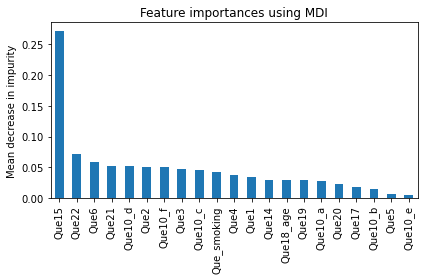

In [16]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Best parameters:
Grid search time: 0:04:19.840685
Mean cross-validation score of best model: 
0.7202655485674354
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 65,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 15}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 65,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 15,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([ 71, 117]))
Test recall:	 0.5983
Test accuracy:	 0.5851
Test precision:	 0.6931
Test ROC AUC:	 0.5808
Test F1 score:	 0.6422
Test confusion matrix:	
[[40 31]
 [47 70]]
Elapsed time to compute the importanc

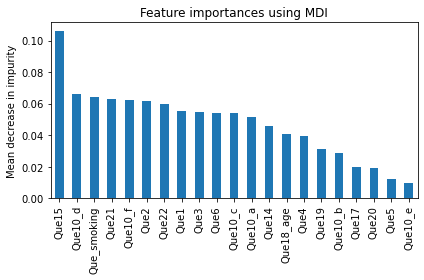

In [17]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [18]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits


KeyboardInterrupt: 

### SMOTEENN

In [ ]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [ ]:
perform_decision_tree(X_train, y_train, X_test, y_test)

### Undersampling

In [ ]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

# Strategy 2 - median

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data_median = pd.DataFrame(imputer.fit_transform(data))
data_median.columns = data.columns
data_median.index = data.index
data_median = perform_mapping(data_median, questions_map_EN)
model_data = data_median.drop(columns=['Que16'])
target_data = data_median['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [ ]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

### Undersampling

In [ ]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

### Oversampling

In [ ]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

### SMOTEENN

In [ ]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

## Random Forest

### No balance

In [ ]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

In [ ]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [ ]:
perform_decision_tree(X_train, y_train, X_test, y_test)

### Undersampling

In [ ]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

# Strategy 3 - mean

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data_mean = pd.DataFrame(imputer.fit_transform(data))
data_mean.columns = data.columns
data_mean.index = data.index
# mean values are not integer numbers so rounding to int was necessary
data_mean = data_mean.round()
data_mean = perform_mapping(data_mean, questions_map_EN)
model_data = data_mean.drop(columns=['Que16'])
target_data = data_mean['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [ ]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

### Undersampling

In [ ]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

### Oversampling

In [ ]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

### SMOTEENN

In [ ]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

## Random Forest

### No balance

In [ ]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

In [ ]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [ ]:
perform_decision_tree(X_train, y_train, X_test, y_test)

### Undersampling

In [ ]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

# Strategy 4 - most frequent

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_most_frequent = pd.DataFrame(imputer.fit_transform(data))
data_most_frequent.columns = data.columns
data_most_frequent.index = data.index
# mean values are not integer numbers so rounding to int was necessary
data_most_frequent = perform_mapping(data_most_frequent, questions_map_EN)
model_data = data_most_frequent.drop(columns=['Que16'])
target_data = data_most_frequent['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [ ]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

### Undersampling

In [ ]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

### Oversampling

In [ ]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

### SMOTEENN

In [ ]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

## Random Forest

### No balance

In [ ]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

### Undersampling

In [ ]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_random_forest(X_train, y_train, X_test, y_test)

## Decision Tree

### No balance

In [ ]:
perform_decision_tree(X_train, y_train, X_test, y_test)

### Undersampling

In [ ]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)